In [433]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA



## Porjet 1: Prédiction du risque d'abandon scolaire

In [434]:
students_df = pd.read_csv("data/Dataset_Abandon_Scolaire.csv", sep=",")

In [435]:
students_df.head()

,Age,Sexe,Taux_presence,Nombre_retards,Note_moyenne,Situation_familiale,Abandon
0,21,Femme,89.585023,2,15.826896,Enfants à charge,0
1,20,Homme,70.713068,3,12.829358,Célibataire,0
2,22,Femme,82.122963,1,13.086319,Enfants à charge,0
3,24,Homme,87.408859,3,14.992032,Célibataire,0
4,20,Homme,86.470676,3,12.671649,Marié,0


In [436]:
students_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  2000 non-null   int64  
 1   Sexe                 2000 non-null   object 
 2   Taux_presence        2000 non-null   float64
 3   Nombre_retards       2000 non-null   int64  
 4   Note_moyenne         2000 non-null   float64
 5   Situation_familiale  2000 non-null   object 
 6   Abandon              2000 non-null   int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 109.5+ KB


==> Le jeu de données est constitué de colonnes numériques :
- Age
- Taux de présence
- Nombre de retards
- Note moyenne
- Abondon

et catégorielles : 
- Sexe
- Situation familiale

In [437]:
students_df['Sexe'].value_counts()

Sexe
Homme    1011
Femme     989
Name: count, dtype: int64

In [438]:
students_df['Situation_familiale'].value_counts()

Situation_familiale
Célibataire         1014
Marié                571
Enfants à charge     302
Divorcé              113
Name: count, dtype: int64

In [439]:
percentages = students_df['Abandon'].value_counts()
percentages = percentages /percentages.sum()*100
percentages

Abandon
0    91.6
1     8.4
Name: count, dtype: float64

==> Analyse 
Il y'a deux classes de catégories : 
- Majoritairement les élèves qui n'abondent pas l'école, représenter par --> 0 soit 91.6%
- et ceux qui l'abandonnent, etiquétés par --> 1 soit par 8.4%

# Embedding data

In [440]:
students_embedding_df = students_df.copy()

In [441]:
# Label encoding colonne Sexe
le = LabelEncoder()
students_embedding_df["Sexe"] = le.fit_transform(students_embedding_df["Sexe"])

In [ ]:
# Sentence transformer colonne Situation familliale
#model =  SentenceTransformer("dangvantuan/sentence-camembert-large")
transformer_model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")


In [ ]:
situation_familliale = students_embedding_df["Situation_familiale"].unique()
situation_familliale_embedding = transformer_model.encode(situation_familliale, show_progress_bar=True)

In [ ]:
# Dict situation familliale & embedding
embedding_dict = {situation : embed for situation, embed in zip(situation_familliale, situation_familliale_embedding)}

# Ajout des embeddings au DataFrame
embedding_dim = situation_familliale_embedding.shape[1] # Dimension des embeddings 
for i in range(embedding_dim):
    students_embedding_df[f'situation_embedding_{i}'] = \
    students_embedding_df['Situation_familiale'].map(lambda x: embedding_dict[x][i])

tagrets_situation_familliale = students_embedding_df["Situation_familiale"]
students_embedding_df.drop("Situation_familiale", axis=1, inplace=True) 
# On supprimme la colonne situation familiale, 
#car elle a été remplacé par son vecteur (numérique) de Sentence Tranformer

In [107]:
students_embedding_df.info()
students_embedding_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 390 entries, Age to situation_embedding_383
dtypes: float32(384), float64(2), int64(4)
memory usage: 3.0 MB


,Age,Sexe,Taux_presence,Nombre_retards,Note_moyenne,Abandon,situation_embedding_0,situation_embedding_1,situation_embedding_2,situation_embedding_3,...,situation_embedding_374,situation_embedding_375,situation_embedding_376,situation_embedding_377,situation_embedding_378,situation_embedding_379,situation_embedding_380,situation_embedding_381,situation_embedding_382,situation_embedding_383
0,21,0,89.585023,2,15.826896,0,0.068562,0.335020,-0.059778,0.007964,...,0.412813,-0.052149,0.085520,0.017431,-0.193396,0.191733,0.111831,0.140096,0.066416,0.203782
1,20,1,70.713068,3,12.829358,0,0.151948,0.088732,-0.185485,0.000529,...,0.098408,-0.092913,0.249011,0.298787,-0.235641,-0.016821,0.143356,-0.256276,0.231025,0.021499
2,22,0,82.122963,1,13.086319,0,0.068562,0.335020,-0.059778,0.007964,...,0.412813,-0.052149,0.085520,0.017431,-0.193396,0.191733,0.111831,0.140096,0.066416,0.203782
3,24,1,87.408859,3,14.992032,0,0.151948,0.088732,-0.185485,0.000529,...,0.098408,-0.092913,0.249011,0.298787,-0.235641,-0.016821,0.143356,-0.256276,0.231025,0.021499
4,20,1,86.470676,3,12.671649,0,0.033296,0.104033,0.072740,0.347456,...,-0.076270,-0.040243,0.255221,0.042167,-0.133812,0.233323,0.233573,-0.185901,-0.041262,0.001271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,23,0,81.800974,3,12.496245,0,0.033296,0.104033,0.072740,0.347456,...,-0.076270,-0.040243,0.255221,0.042167,-0.133812,0.233323,0.233573,-0.185901,-0.041262,0.001271
1996,20,1,84.082873,4,13.125663,0,0.151948,0.088732,-0.185485,0.000529,...,0.098408,-0.092913,0.249011,0.298787,-0.235641,-0.016821,0.143356,-0.256276,0.231025,0.021499
1997,19,0,87.114146,1,13.841282,0,0.151948,0.088732,-0.185485,0.000529,...,0.098408,-0.092913,0.249011,0.298787,-0.235641,-0.016821,0.143356,-0.256276,0.231025,0.021499
1998,20,0,83.799064,3,12.061256,0,0.151948,0.088732,-0.185485,0.000529,...,0.098408,-0.092913,0.249011,0.298787,-0.235641,-0.016821,0.143356,-0.256276,0.231025,0.021499


==> Analyse de traitement de données catégorielles du dataframe
- Après le label encoding sur la colonne "sexe" et le l'embedding sur la 
colonne "situation familiale", le jeu de données est propre et constitué uniquement des données numériques avec 390 colonnes et 2000 lignes
- Les 384 colonnes sont rajoutés par l'embedding (vecteur pour chaque situation familiale)

## Séparation de données en features et targets.

In [ ]:
# Séparation du dataframe en target et features pour entrainer le modèle
target_abondon = students_embedding_df['Abandon']
features_students = students_embedding_df.drop('Abandon', axis=1)


# Normalisation standard de données

In [ ]:
## Normalisation 
standard_scaler_object = StandardScaler()
features_students_scaled = standard_scaler_object.fit_transform(features_students)

## Split de données en train et test
X_train, X_test, y_train, y_test = train_test_split(features_students_scaled, \
                                        target_abondon, random_state=42)

## Le modèle : KNN

In [412]:
## fonction de recherche des meilleurs parametres du KNN avec cross validation 
def get_optimal_parameters(scaled_features, solution_target):
    n_folds = StratifiedKFold(n_splits=5)
    parameters = {"n_neighbors": np.arange(start=1, stop=15, step=1),
                  "weights": ["distance"], 
                  "metric": ["euclidean", "manhattan", "minkowski"] 
                  }
    k_neighbors_classifier_model = KNeighborsClassifier()
    grid_search_object = GridSearchCV(
            estimator=k_neighbors_classifier_model, 
            param_grid=parameters,
            scoring = "f1_macro", 
            cv=n_folds,
            verbose=1)
    grid_search_object.fit(scaled_features, solution_target)
    best_estimator = grid_search_object.best_estimator_
    scores = pd.DataFrame(grid_search_object.cv_results_)
    best_params = grid_search_object.best_params_

    return best_estimator, scores, best_params

In [453]:
best_estimator, scores, best_params = get_optimal_parameters(X_train, y_train)
print(f"Meilleur paramètre 'K' : \n{best_params}")
print(f"Best estimator : {best_estimator}")

Fitting 5 folds for each of 42 candidates, totalling 210 fits
Meilleur paramètre 'K' : 
{'metric': 'manhattan', 'n_neighbors': np.int64(9), 'weights': 'distance'}
Best estimator : KNeighborsClassifier(metric='manhattan', n_neighbors=np.int64(9),
                     weights='distance')


==> Analyse du résultat : 
 - Le meilleur paramètre K voisins proches est 9.
- Weight à "distance", par ce que, pour donner plus d'importances aux voisins les plus proches, ainsi, on peut capturer les classes minotritaires (0)
- La distance de Manhattan est la meilleur métric.

In [454]:
scores[scores['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
22,0.000818,0.000108,0.032141,0.000658,manhattan,9,distance,"{'metric': 'manhattan', 'n_neighbors': 9, 'wei...",0.754742,0.684629,0.739476,0.780693,0.754742,0.742856,0.031987,1


==> Analyse 
- Meilleur score moyen du modèle : 74.28%

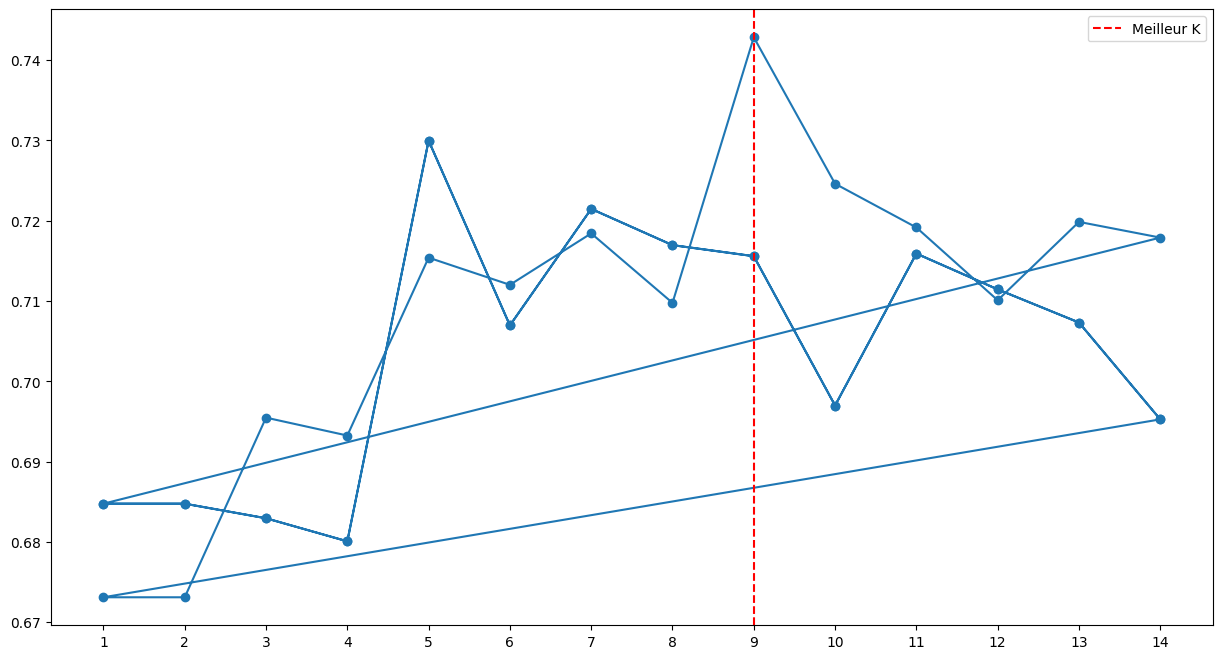

In [455]:
# Plot du scores avec les parametres testés
plt.figure(figsize=(15, 8))
plt.xticks(np.arange(1, 15))
plt.plot(scores["param_n_neighbors"], scores["mean_test_score"], "o-")
plt.axvline(x=best_params['n_neighbors'], color="r", linestyle="--", label="Meilleur K")
plt.legend()
plt.show()

==> Conclusion :
- Le meilleur parametre sur le nombre de voisins le plus proche de ce modèle KNN est 9, sur les différents candidats testés.
- Pour un score moyen de 74.28%.

In [456]:
## Le modèle
k_neighbors_classifier_object =  KNeighborsClassifier(n_neighbors=9)
k_neighbors_classifier_object.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=9)

In [457]:
y_pred = k_neighbors_classifier_object.predict(X_test)
print("Classification Report sur notre modèle KNN")
print(classification_report(y_test, y_pred))

Classification Report sur notre modèle KNN
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       463
           1       0.83      0.41      0.55        37

    accuracy                           0.95       500
   macro avg       0.89      0.70      0.76       500
weighted avg       0.95      0.95      0.94       500



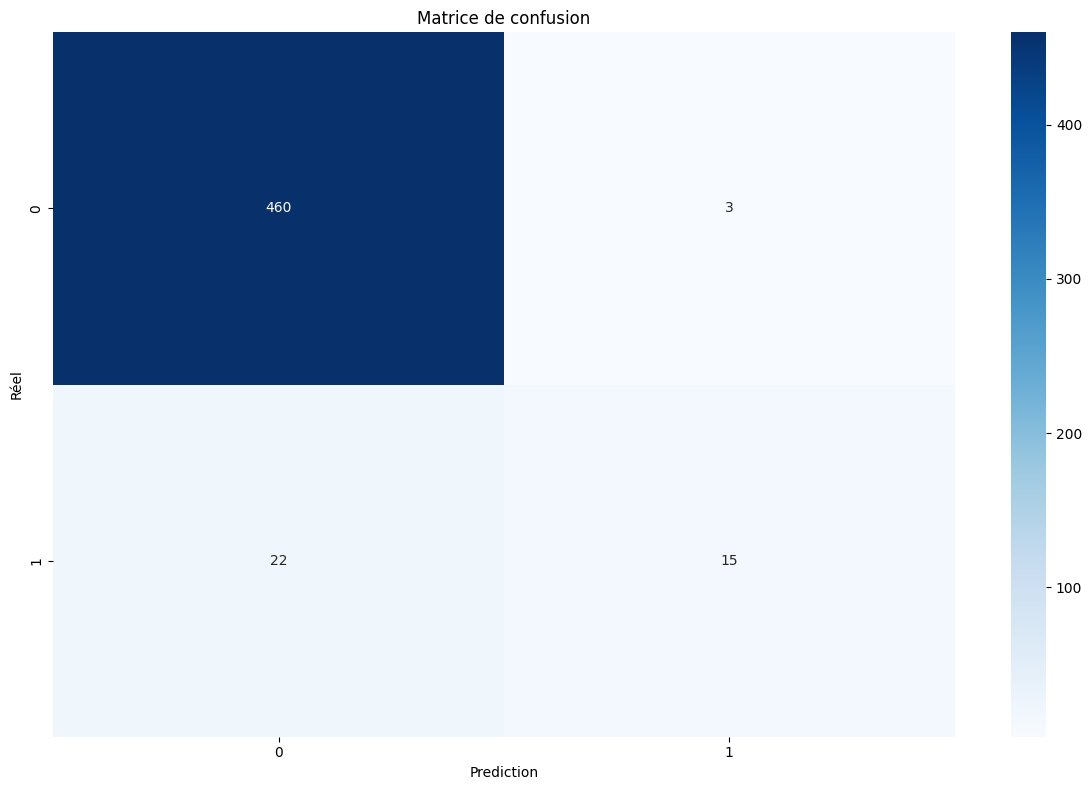

In [458]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12 , 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.title('Matrice de confusion')
plt.xlabel('Prediction')
plt.ylabel('Réel')
plt.tight_layout()
plt.show()

==> Analyse sur la matrice de confusion : 
- On constate que, notre modèle fait de bonnes predictions sur la classe 0: 460 (non abondon) et mauvaises prédictions 22, alors qu'ils devraient l'etre dans la classe 1 abandon.
- Sur la classe 1, le modèle fait de prédictions optimales 15, et mauvaises prédictions 3.

## Réduction de dimensionnalité :  PCA

In [459]:
corr_students = students_embedding_df[['Age', 'Sexe', 'Taux_presence', 'Nombre_retards', 'Note_moyenne']].corr()

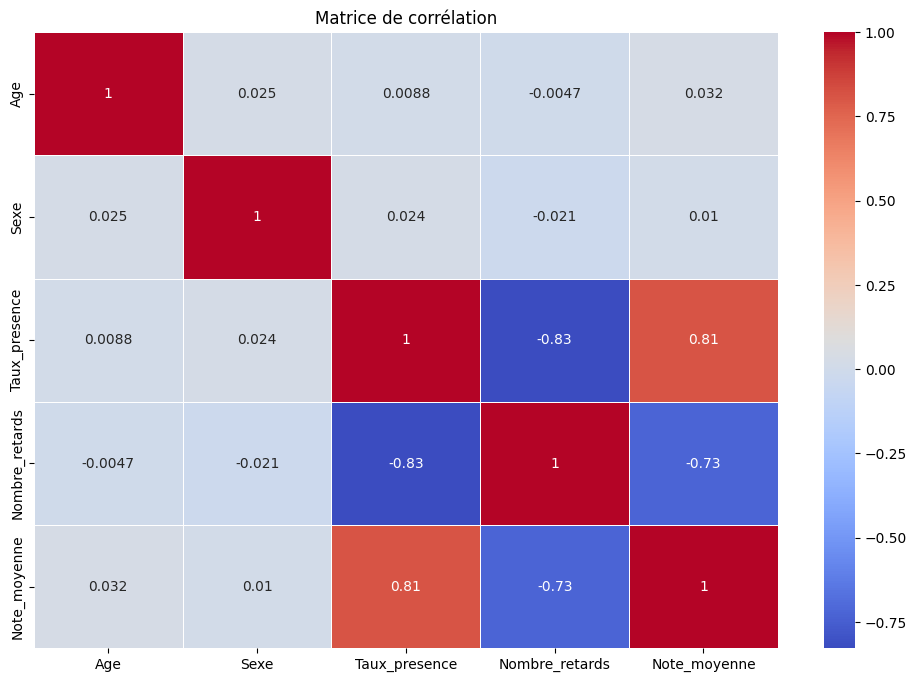

In [460]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_students, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Matrice de corrélation")
plt.show()

- D'après la matrice de corrélation, il existe une corrélation forte entre les feautures du jeu de données:
    - "Taux de présence", "Nombre de retards", "la note moyenne", 

In [462]:
## Reduction de dimensionnalité : PCA
pca_object = PCA()
features_students_scaled_component_pca = pca_object.fit_transform(features_students_scaled)
valeurs_propres_expl_var = pca_object.explained_variance_ratio_
cumulative_variance = np.cumsum(valeurs_propres_expl_var)

In [463]:
for i, var in enumerate(cumulative_variance):
    print(f"Composante {i+1} {var:.2%} de données")
    if i==9:
        break

Composante 1 41.11% de données
Composante 2 72.17% de données
Composante 3 98.72% de données
Composante 4 99.38% de données
Composante 5 99.64% de données
Composante 6 99.89% de données
Composante 7 99.96% de données
Composante 8 100.00% de données
Composante 9 100.00% de données
Composante 10 100.00% de données


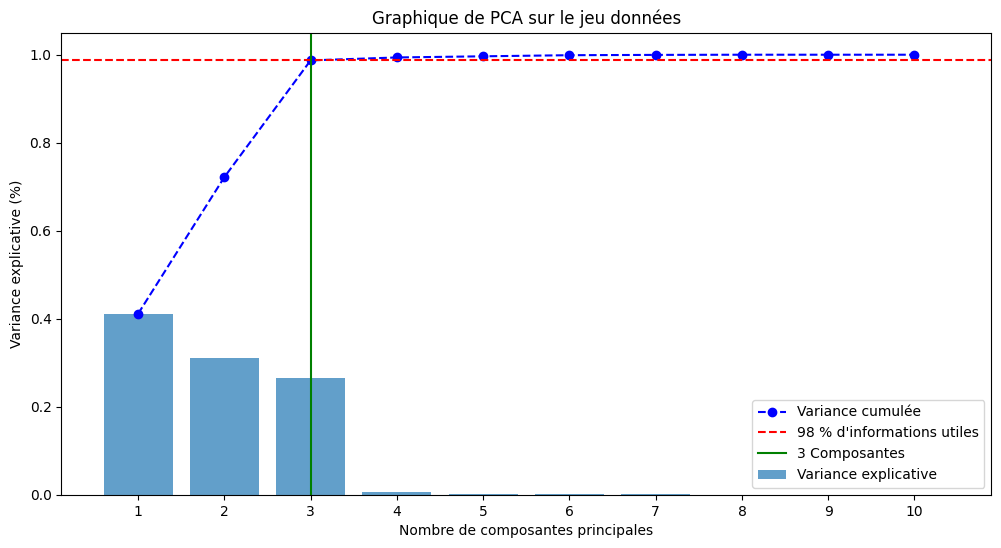

In [464]:
# Plot de la variance explicative & cumulative
plt.figure(figsize=(12, 6))
plt.xticks(ticks=range(1, 21))
plt.bar(range(1, len(cumulative_variance[:10]) + 1), valeurs_propres_expl_var[:10], alpha=0.7, label='Variance explicative')
plt.plot(range(1,len(cumulative_variance[:10]) + 1), cumulative_variance[:10], "bo--", label='Variance cumulée')
plt.axhline(y=0.98715265, color="red", linestyle="--", label="98 % d'informations utiles")
plt.axvline(x=3, color = "green", linestyle='-', label='3 Composantes')
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Variance explicative (%)")
plt.title("Graphique de PCA sur le jeu données")
plt.legend()
plt.show()

In [465]:
print(f"Variance expliactive : {len(valeurs_propres_expl_var)}\nVariance cumulée : {len(cumulative_variance)}\
      \nDonnées du dataframe : {features_students.shape}")

Variance expliactive : 389
Variance cumulée : 389      
Données du dataframe : (2000, 389)


==> Analyse du résultat
- Avec la PCA, on ne garde que trois composantes et sans pour autant perdre  d'informations, soit 98% de ces informations seront conservées et l'entrainement du modèle peut être plus rapide + memoire optimale.
- Par ailleurs, après la transformation (embdedding), le dataframe a 389 colonnes sans le target "Abandon", ce qui est norme pour une inteprétation graphique.

/var/folders/xk/wdvvwyvn0jbg64rqx83zfpmr0000gn/T/ipykernel_1372/2662829379.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


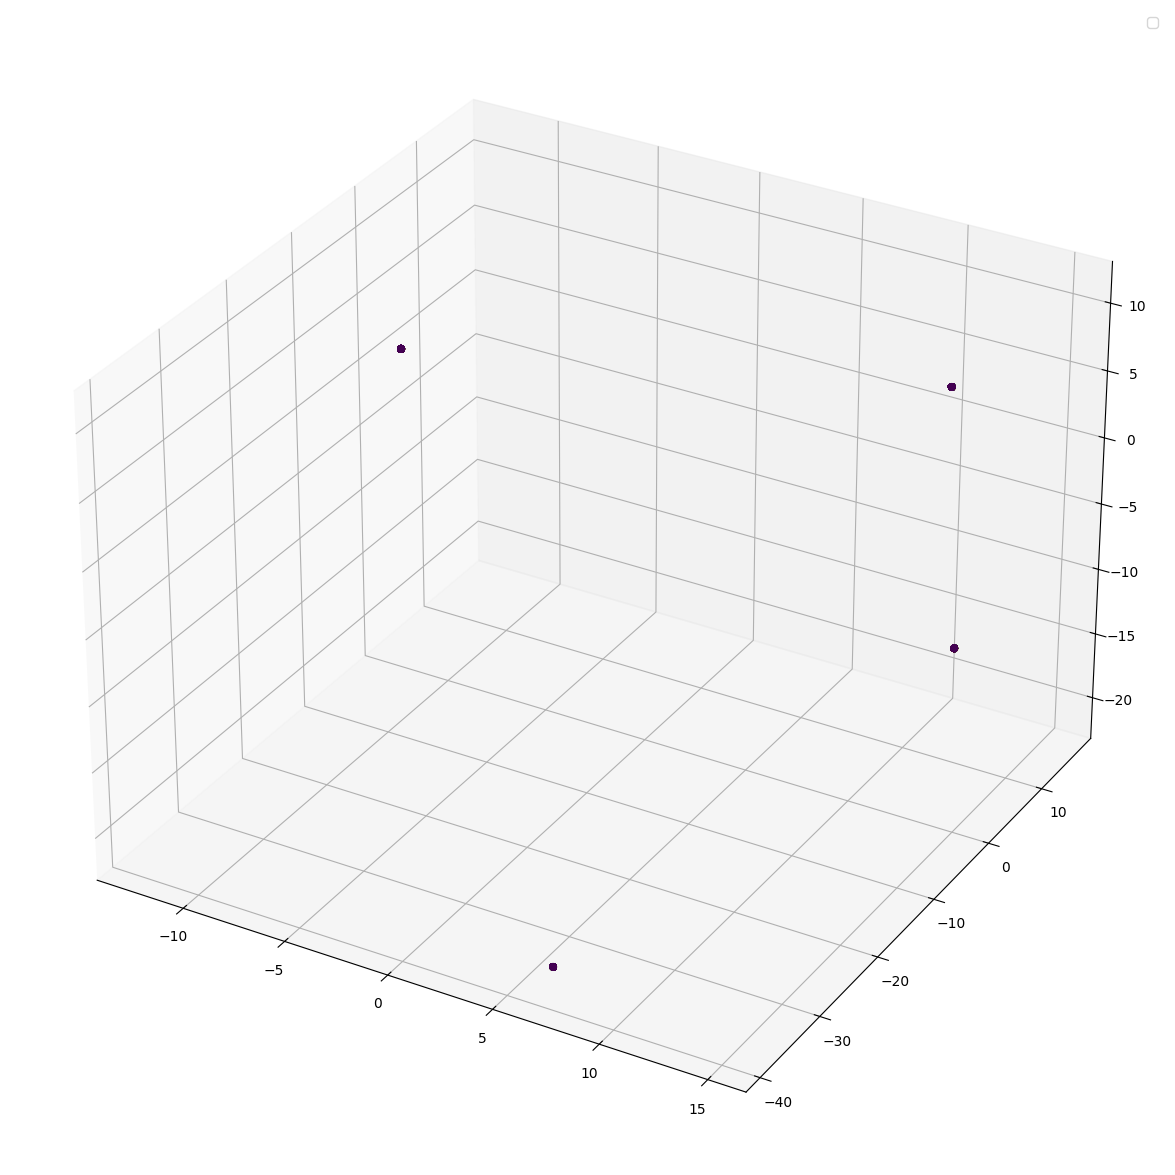

In [466]:
## Afichage en 3D
view_colors = {0: "blue", 1: "red", 2: "green"}
figure = plt.figure(figsize=(20, 15))
ax = figure.add_subplot(projection="3d")
ax.scatter(features_students_scaled_component_pca[:, 0], features_students_scaled_component_pca[:, 1],\
           features_students_scaled_component_pca[:, 2], c=target_abondon, cmap='viridis', alpha=0.6)
plt.legend()
plt.show()